# data formating

- 다운로드한 데이터셋 512 *512 *30(frame)

In [1]:
# 패키치 임포트
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
dir_data = '/content/drive/MyDrive/Colab Notebooks/pytorch/'

In [10]:
# 데이터 로드



name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

nx, ny = img_label.size
nframe = img_label.n_frames

In [11]:
print("nx = " ,nx)
print("ny = " ,ny)
print("nframe = ", nframe)

nx =  512
ny =  512
nframe =  30


In [13]:
# 30 프레임중 24개는 train, 3개는 val, 3개는 test
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

# 디렉토리 생성
if not os.path.exists(dir_save_train):
  os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
  os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
  os.makedirs(dir_save_test)



In [18]:
# 프레임 셔플
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)
print(id_frame)

[13  2 14 28 11 24  1 16  8 10 18 27 21 25 20  9 19 17  3 12  4 26  0  6
 15 29 22  5 23  7]


In [ ]:
# 셔플된 프레임 저장
offset_nframe  =0
for i in range(nframe_train):
  img_label.seek(id_frame[i + offset_nframe])
  img_input.seek(id_frame[i + offset_nframe])

  label_ = np.asarray(img_label)
  input_ = np.asarray(img_input)
  print("label_ =",label_)
  print("input_ =",input_)
  print("=" *100)
  np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
  np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

In [23]:
# 셔플된 프레임 저장
offset_nframe  += nframe_train
for i in range(nframe_val):
  img_label.seek(id_frame[i + offset_nframe])
  img_input.seek(id_frame[i + offset_nframe])

  label_ = np.asarray(img_label)
  input_ = np.asarray(img_input)
  print("label_ =",label_)
  print("input_ =",input_)
  print("=" *100)
  np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
  np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

label_ = [[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
input_ = [[181 172 169 ... 122  80  77]
 [184 182 166 ...  83  81  59]
 [211 208 196 ...  89  70  99]
 ...
 [142 108 103 ... 153 141 138]
 [105  82  67 ... 153 135 141]
 [112  81  71 ... 137 137 184]]
label_ = [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
input_ = [[ 74  90  68 ... 139 114 132]
 [ 63  74  48 ... 108 107 103]
 [ 37  43  42 ... 101 100  80]
 ...
 [140 135 123 ... 213 190 185]
 [ 94 105 124 ... 201 194 192]
 [ 97  90  99 ... 199 199 201]]
label_ = [[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 2

In [24]:
# 셔플된 프레임 저장
offset_nframe  += nframe_val
for i in range(nframe_test):
  img_label.seek(id_frame[i + offset_nframe])
  img_input.seek(id_frame[i + offset_nframe])

  label_ = np.asarray(img_label)
  input_ = np.asarray(img_input)

  np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
  np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

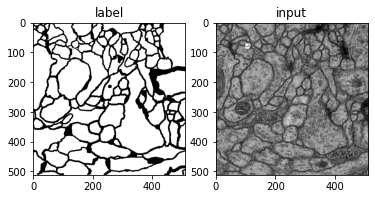

In [26]:
plt.subplot(121)
plt.imshow(label_, cmap ='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap ='gray')
plt.title('input')
plt.show()

# Unet 구현

In [3]:
import os 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets

In [4]:
 # 파라미터 설정
 lr = 1e-3
 batch_size = 4
 num_epoch =100

 data_dir = '/content/drive/MyDrive/Colab Notebooks/pytorch'
 ckpt_dir = '/content/ckeckpoint'
 log_dir = '/content/log'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
print(device)

cuda


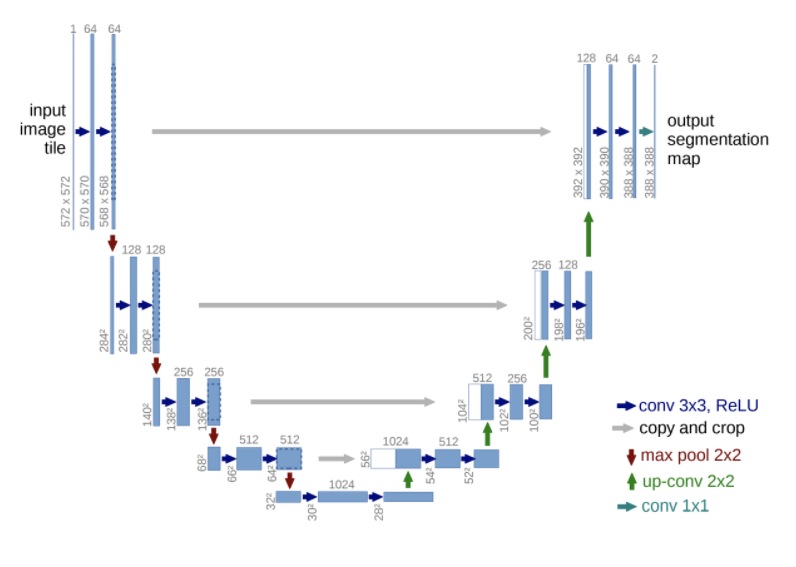

In [ ]:
#Unet 구현
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 논문의 파란색 화살표
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            # Conv2d layer 정의
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        # 좌측 레이어 enc (인코더)
        # 1층 좌측 첫번째 레이어 두개 
        self.enc1_1 = CBR2d(in_channels=1, out_channels =64, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc1_2 = CBR2d(in_channels=64, out_channels =64, kernel_size =3, stride=1, padding =1, bias =True)

        # 다음 빨간색 화살표 max_pool 2*2
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # 2층 파란색 화살표     
        self.enc2_1 = CBR2d(in_channels=64, out_channels =128, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc2_2 = CBR2d(in_channels=128, out_channels =128, kernel_size =3, stride=1, padding =1, bias =True)
        
        # 다음 빨간색 화살표 max_pool 2*2
        self.pool2 = nn.MaxPool2d(kernel_size =2)

        # 3층 파란색 화살표 
        self.enc3_1 = CBR2d(in_channels=128, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc3_2 = CBR2d(in_channels=256, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)

        # 다음 빨간색 화살표 max_pool 2*2
        self.pool3 = nn.MaxPool2d(kernel_size =2)


        # 4층 파란색 화살표 
        self.enc4_1 = CBR2d(in_channels=256, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)
        self.enc4_2 = CBR2d(in_channels=512, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)

        # 다음 빨간색 화살표 max_pool 2*2
        self.pool4 = nn.MaxPool2d(kernel_size =2)

        # 5층 파란색 화살표
        self.enc5_1 = CBR2d(in_channels=512, out_channels =1024, kernel_size =3, stride=1, padding =1, bias =True)


        # Expansive path
        
        # 5층 파란색 2번쨰 화살표인데 디코더로
        self.dec5_1 = CBR2d(in_channels=1024, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)

        # 초록색 화살표
        self.unpool4 = nn.ConvTranspose2d(in_channels =512, out_channels = 512, kernel_size = 2, stride = 2, padding = 0, bias = True)

        # enc4_2와 대칭이되는 점을 보면 dec4_2 input값은 512가 맞는데, unet 아키텍쳐를 보니
        # enc4_2 에서 회색 화살표로 dec4_2로 와서 copy and crop이 일어남
        # 따라서 dec4_2 in_channels = 1024로 설정
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels =512, kernel_size =3, stride=1, padding =1, bias =True)
        self.dec4_1 = CBR2d(in_channels=512, out_channels =256, kernel_size =3, stride=1, padding =1, bias =True)

        # 초록색 화살표
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        # 3층 파란색 화살표
        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        # 초록색 화살표
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        
        # 2층 파란색 화살표
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        # 초록색 화살표
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        
        # 1층 파란색 화살표
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        # segmentation에 필요한 n개의 클래스에 대한 output 정의
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):

        # 좌측 1층 레이어 2개 연결 및 빨간색 화살표
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        # 좌측 2층 레이어 2개 연결 및 빨간색 화살표
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc1_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        # 좌측 3층 레이어 2개 연결 및 빨간색 화살표
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        # 좌측 4층 레이어 2개 연결 및 빨간색 화살표
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        # 좌측 5층 레이어
        enc5_1 = self.enc5_1(pool4)

        # 우측 5층 레이어 및 초록색 화살표
        dec5_1 = self.dec5_1(enc5_1)
        unpool4 = self.unpool4(dec5_1)

        # 하얀색 부분 연결하기
        cat4 = torch.cat((unpool4, enc4_2),dim =1)

        # 파란색 화살표 실행
        # cat에서 512 + 512 로 1024의 레이어 만들고 파란색 화살표 수행후 아웃풋값을 512로 만듬
        dec4_2 = self.dec4_2(cat4)

        # 여기까지 하면 우측 4층 레이어까지 생성
        dec4_1 = self.dec4_1(dec4_2)

        # 반복 3층
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2),dim =1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        # 반복 2층
        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2),dim =1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        # 반복 1층
        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2),dim =1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [8]:
import os
import numpy as np

import torch
import torch.nn as nn

## 데이터 로더를 구현하기
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        # 데이터 준비할때 데이터셋 명을 아래와 같이 만듬
        # input_001, input_002, label_001, label_002 
        # input , label와 같이 prefix된 word를 사용해서 리스트에 추가

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        label = label/255.0
        input = input/255.0
        # 채널이 없는 경우 늘리기
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data


In [9]:
## 데이터로더 확인
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'))

In [10]:
data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

In [ ]:
input[0]

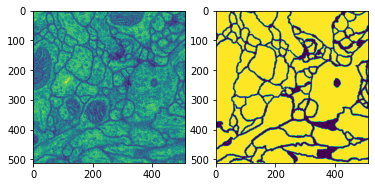

In [13]:
plt.subplot(121)
# squeeze()를 사용해 channel처리후 시각화
plt.imshow(input.squeeze())

plt.subplot(122)
plt.imshow(label.squeeze())
plt.show()

In [14]:
## 트랜스폼 구현

# numpy to tensor
class ToTensor(object):
  def __call__(self, data):

    # image numpy 차원 = (y,x, channel)
    # image tensor 차원 = (ch , y, x)
    label, input = data['label'], data['input']
    
    label = label.transpose((2, 0, 1)).astype(np.float32)
    input = input.transpose((2, 0, 1)).astype(np.float32)

    data = {'label' : torch.from_numpy(label),
            'input' : torch.from_numpy(input)}
    return data

class Normalization(object):
  def __init__(self, mean=0.5 , std=0.5):
    self.mean = mean
    self.std = std
  
  def __call__(self, data):
    label, input = data['label'], data['input']

    input =(input - self.mean) / self.std
    data = {'label' : label,
            'input' : input}
    return data

class RandomFlip(object):
  def __call__(self, data):
    label, input = data['label'], data['input']

    if np.random.rand() > 0.5:
      label = np.fliplr(label)
      input = np.fliplr(input)
    if np.random.rand() > 0.5:
      label = np.flipud(label)
      input = np.flipud(input)

    data ={'label' : label, 'input' : input}
    return data

# Train

In [15]:
# 트랜스폼
transform = transforms.Compose([Normalization(mean= 0.5, std =0.5),
                                RandomFlip(),
                                ToTensor()])

# dataset_train
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'), transform =transform)
loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle =True, num_workers = 8)

dataset_val = Dataset(data_dir = os.path.join(data_dir, 'val'), transform =transform)
loader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle =False, num_workers = 8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
# 네트워크 생성
net = UNet().to(device)

# 손실함수 정의
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 생성
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 부수적인 variables
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# output을 저장하기 위한 함수

# tensor to numpy
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)

# norm to denorm
fn_denorm = lambda x, mean, std: (x * std) + mean

# network output을 binary로 분류
fn_class = lambda x: 1.0 * (x > 0.5)

## Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

In [21]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, 

In [24]:
net, optim, st_epoch = load(ckpt_dir = ckpt_dir, net =net, optim =optim)

# 학습
st_epoch = 0
for epoch in range(st_epoch + 1, num_epoch +1):
  net.train()
  loss_arr = []

  for batch, data in enumerate(loader_train, 1):
    # forward pass
    label = data['label'].to(device)
    input = data['input'].to(device)
    output = net(input)
    

    # backward pass
    optim.zero_grad()
    loss = fn_loss(output, label)
    loss.backward()

    optim.step()

    # 손실함수 계산
    loss_arr +=[loss.item()]
    print("Train : Epoch %04d / %04d | Batch %04d / %04d | Loss %.4f"% (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
    
    # 텐서보드에 저장
    label = fn_tonumpy(label)
    input= fn_tonumpy(fn_denorm(input, mean = 0.5, std =0.5))
    output = fn_tonumpy(fn_class(output))

    
    writer_train.add_image('label', label, num_batch_train * (epoch -1) + batch, dataformats ='NHWC')
    writer_train.add_image('input', input, num_batch_train * (epoch -1) + batch, dataformats ='NHWC')
    writer_train.add_image('output', output, num_batch_train * (epoch -1) + batch, dataformats ='NHWC')
  writer_train.add_scalar('loss', np.mean(loss_arr), epoch)


  # validation
  with torch.no_grad():
    net.eval()
    loss_arr = []
    for batch, data in enumerate(loader_val, 1):

      # forward pass
      label = data['label'].to(device)
      input = data['input'].to(device)

      output = net(input)

      # 손실함수 계산하기
      loss = fn_loss(output, label)
      loss_arr +=[loss.item()]
      print("Train : Epoch %04d / %04d | Batch %04d / %04d | Loss %.4f"% (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
      label = fn_tonumpy(label)
      input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
      output = fn_tonumpy(fn_class(output))
      writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
      writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
      writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

  writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
  if epoch % 5 == 0:
    save(ckpt_dir = ckpt_dir, net = net, optim= optim, epoch = epoch)
writer_train.close()
writer_val.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train : Epoch 0001 / 0100 | Batch 0001 / 0006 | Loss 0.4458
Train : Epoch 0001 / 0100 | Batch 0002 / 0006 | Loss 0.4632
Train : Epoch 0001 / 0100 | Batch 0003 / 0006 | Loss 0.4497
Train : Epoch 0001 / 0100 | Batch 0004 / 0006 | Loss 0.4454
Train : Epoch 0001 / 0100 | Batch 0005 / 0006 | Loss 0.4372
Train : Epoch 0001 / 0100 | Batch 0006 / 0006 | Loss 0.4297
Train : Epoch 0001 / 0100 | Batch 0001 / 0006 | Loss 0.4971
Train : Epoch 0002 / 0100 | Batch 0001 / 0006 | Loss 0.4038
Train : Epoch 0002 / 0100 | Batch 0002 / 0006 | Loss 0.3931
Train : Epoch 0002 / 0100 | Batch 0003 / 0006 | Loss 0.3874
Train : Epoch 0002 / 0100 | Batch 0004 / 0006 | Loss 0.3858
Train : Epoch 0002 / 0100 | Batch 0005 / 0006 | Loss 0.3836
Train : Epoch 0002 / 0100 | Batch 0006 / 0006 | Loss 0.3811
Train : Epoch 0002 / 0100 | Batch 0001 / 0006 | Loss 0.4379
Train : Epoch 0003 / 0100 | Batch 0001 / 0006 | Loss 0.3462
Train : Epoch 0003 / 0100 | Batch 0002 / 0006 | Loss 0.3509
Train : Epoch 0003 / 0100 | Batch 0003 /

KeyboardInterrupt: ignored